# MultIVAP CIFAR-10 example

This notebook demonstrates basic usage of our MultIVAP algorithm on a convolutional neural network for the CIFAR-10 data set.

First, we import the necessary modules:

In [1]:
import cifar10
import numpy as np
import keras
import matplotlib.pyplot as plt

from multivap import MultIVAP
from tabulate import tabulate
from whitebox import WhiteboxAttack

Using TensorFlow backend.


We define a couple of utility functions for data normalization and visualization of results:

In [2]:
def normalize(arr):
    min_val, max_val = arr.min(), arr.max()
    arr -= min_val
    arr /= max_val - min_val
    return arr

def heatmap(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='gray')
    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    ax.set_xticklabels([i+1 for i in range(cm.shape[0])])
    ax.set_yticklabels([i+1 for i in range(cm.shape[1])])
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, int(cm[i, j]),
                           ha="center", va="center", color="red")
    fig.tight_layout()

def print_metrics(metrics):
    print(tabulate([
        ['Accuracy', metrics.acc],
        ['Efficiency', '{} <= {} <= {}'.format(metrics.eff_lower, metrics.eff, metrics.eff_upper)],
        ['Rejection', metrics.rej],
        ['TRR', metrics.trr],
        ['FRR', metrics.frr]
    ]))

Now we can load the data and prepare the training, calibration, validation and test sets:

In [3]:
# load data
x_train, y_train, x_test, y_test = cifar10.load_datasets()

# normalize the data set
x_train = normalize(x_train.astype(np.float64))
x_test = normalize(x_test.astype(np.float64))

# splits for proper training, proper testing, calibration and validation sets
idx = int(.8*x_train.shape[0])
x_proper_train, y_proper_train = x_train[:idx], y_train[:idx]
x_calib, y_calib = x_train[idx:], y_train[idx:]

idx = int(.8*x_test.shape[0])
x_proper_test, y_proper_test = x_test[:idx], y_test[:idx]
x_valid, y_valid = x_test[idx:], y_test[idx:]

print('Training samples: {}'.format(x_proper_train.shape))
print('Calibration samples: {}'.format(x_calib.shape))
print('Test samples: {}'.format(x_test.shape))
print('Validation samples: {}'.format(x_valid.shape))

Training samples: (40000, 32, 32, 3)
Calibration samples: (10000, 32, 32, 3)
Test samples: (10000, 32, 32, 3)
Validation samples: (2000, 32, 32, 3)


We then create and fit the model as specified in `cifar10.py`:

In [4]:
model = cifar10.create_model()
model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=cifar10.get_optimizer(),
                metrics=['accuracy'])
model.fit(x_proper_train, y_proper_train,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_data=(x_valid, y_valid))

W0828 14:06:02.427728 140274115786560 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 14:06:02.471475 140274115786560 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 14:06:02.493202 140274115786560 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 14:06:02.595081 140274115786560 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0828 14:06:02.6367

Train on 40000 samples, validate on 2000 samples
Epoch 1/10
40000/40000 [==============================] - 19s 477us/step - loss: 1.5796 - acc: 0.4235 - val_loss: 1.2798 - val_acc: 0.5260
Epoch 2/10
40000/40000 [==============================] - 5s 130us/step - loss: 1.1772 - acc: 0.5813 - val_loss: 1.0720 - val_acc: 0.6120
Epoch 3/10
40000/40000 [==============================] - 5s 133us/step - loss: 1.0058 - acc: 0.6405 - val_loss: 0.9751 - val_acc: 0.6615
Epoch 4/10
40000/40000 [==============================] - 6s 142us/step - loss: 0.8752 - acc: 0.6907 - val_loss: 0.8440 - val_acc: 0.7080
Epoch 5/10
40000/40000 [==============================] - 5s 124us/step - loss: 0.7770 - acc: 0.7263 - val_loss: 0.8009 - val_acc: 0.7175
Epoch 6/10
40000/40000 [==============================] - 6s 147us/step - loss: 0.7008 - acc: 0.7540 - val_loss: 0.7912 - val_acc: 0.7205
Epoch 7/10
40000/40000 [==============================] - 6s 138us/step - loss: 0.6314 - acc: 0.7785 - val_loss: 0.7867 - 

Once the model is trained, we can calibrate the MultIVAP:

In [5]:
multivap = MultIVAP(model, x_calib, y_calib, y_test.shape[1])

Using the held-out validation data set, the significance level $\varepsilon$ can be tuned so that the predictive efficiency is as close to one as possible:

In [6]:
best_beta, _ = multivap.tune(x_valid)
print('Significance level: {}'.format(best_beta))

Significance level: 0.21176475286483765


We now evaluate the performance of the tuned MultIVAP on the regular test data:

----------  ----------------------
Accuracy    0.8313465783664459
Efficiency  0.0 <= 1.025875 <= 2.0
Rejection   0.150625
TRR         0.3315677966101695
FRR         0.09473167539267016
----------  ----------------------


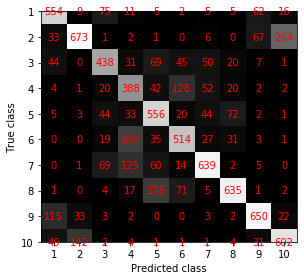

In [7]:
cm, metrics = multivap.evaluate(x_proper_test, y_proper_test, best_beta)
print_metrics(metrics)
heatmap(cm)

## White-box adversarial attack

We also demonstrate how to use our custom white-box attack to generate adversarial examples for the MultIVAP. We first instantiate the attack with the MultIVAP, the underlying model, the calibration data and the batch size:

In [8]:
whitebox = WhiteboxAttack(multivap, model, x_calib, y_calib, batch_size=128)

W0828 14:09:08.702240 140274115786560 deprecation.py:506] From /scratch/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0828 14:09:09.169498 140274115786560 deprecation_wrapper.py:119] From /home/jpeck/multivap/whitebox.py:37: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Generating adversarial examples is then easily done as follows:

In [ ]:
x_advs, flags = whitebox.attack(x_proper_test, y_proper_test, eta=0.03, beta=best_beta, its=100)

  2%|▏         | 1/62 [02:14<2:17:14, 134.99s/it]

The arrays `x_advs` and `flags` contain the actual adversarial examples and flags indicating which adversarials count as a success. This allows us to easily compute the success rate:

In [ ]:
print('Success rate: {}\n'.format(flags.mean()))